We aim to understand the meaning of the terms in the kernel Stein discrepancy.

Using the inverse multiquadratic kernel
$$k(x, y) = \left(c^2 + \|\Gamma^{-1/2}(x-y)\|\right)^\beta,$$
the kernel of Stein discrepancy can be written as
$$\begin{split}
k_P(x, y) = 
&-4 \beta(\beta-1) D^{\beta-2} \| \Gamma^{-1}(x - y)\|^2 \\
&- 2 \beta D^{\beta-1} (\text{trace}(\Gamma^{-1}) + \langle \Gamma^{-1} (x - y), \nabla_x \log p(x) - \nabla_y \log p(y)\rangle)\\
&+ D^\beta \langle \nabla_x \log p(x), \nabla_y \log p(y) \rangle
\end{split}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal as mvn

from stein_thinning.kernel import vfk0_imq

from utils.mvn import make_mvn_mixture

In [2]:
mean = np.array([0., 0.])
cov = np.array([
    [2.0, np.sqrt(3.) * 0.8],
    [np.sqrt(3.) * 0.8, 1.5],
])

In [3]:
rvs, logpdf, score, logpdf_jax = make_mvn_mixture(
    weights=np.array([1.]),
    means=np.array([[0., 0.]]),
    covs=np.array([[
        [2.0, np.sqrt(3.) * 0.8],
        [np.sqrt(3.) * 0.8, 1.5],
    ]]),
)

In [4]:
x0 = np.array([[0.6, 0.4]])
linv = np.identity(2)

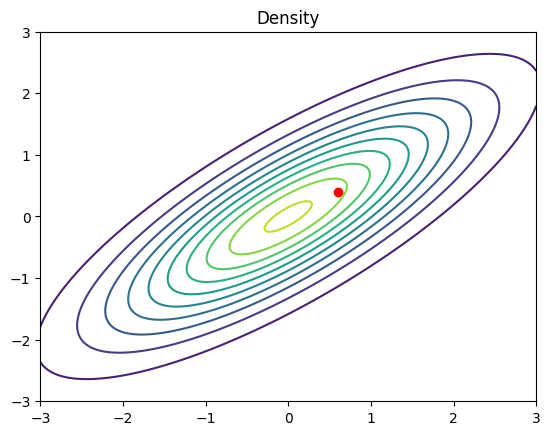

In [5]:
xlim = (-3., 3.)
ylim = (-3., 3.)
mesh_size = 200
levels = 10

x = np.linspace(*xlim, mesh_size)
y = np.linspace(*ylim, mesh_size)
xy = np.moveaxis(np.stack(np.meshgrid(x, y)), 0, 2).reshape(mesh_size * mesh_size, 2)
z = np.exp(logpdf(xy)).reshape(mesh_size, mesh_size)

fig, ax = plt.subplots()
ax.contour(x, y, z, levels=levels);
ax.scatter(x0[0, 0], x0[0, 1], color='red');
ax.set_title('Density');

In [24]:
def vfk0_imq_terms(
        x: np.ndarray,
        y: np.ndarray,
        sx: np.ndarray,
        sy: np.ndarray,
        linv: np.ndarray,
        c: float = 1.0,
        beta: float = -0.5,
    ) -> np.ndarray:
    xmy = x.T - y.T
    qf = c + np.sum(np.dot(linv, xmy) * xmy, axis=0)
    t1 = -4 * beta * (beta - 1) * np.sum(np.dot(np.dot(linv, linv), xmy) * xmy, axis=0) * qf ** (beta - 2)
    t2 = -2 * beta * np.trace(linv) * qf ** (beta - 1)
    t3 = -2 * beta * np.sum(np.dot(linv, sx.T - sy.T) * xmy, axis=0) * qf ** (beta - 1)
    t4 = np.sum(sx.T * sy.T, axis=0) * qf ** beta
    return t1, t2, t3, t4

In [25]:
def evaluate(y):
    x = x0.repeat(y.shape[0], axis=0)
    sx = score(x)
    sy = score(y)
    t1, t2, t3, t4 = vfk0_imq_terms(x, y, sx, sy, linv)
    return t1 + t2 + t3 + t4, t1, t2, t3, t4

In [26]:
kernel, t1, t2, t3, t4 = evaluate(xy)

In [27]:
def show_contour(ax, vals, title, levels=10):
    vals = vals.reshape(mesh_size, mesh_size)
    cs = ax.contour(x, y, vals, levels=levels);
    ax.clabel(cs, fmt='%2.1f', fontsize=6);
    ax.set_title(title);
    ax.scatter(x0[0, 0], x0[0, 1], color='red');

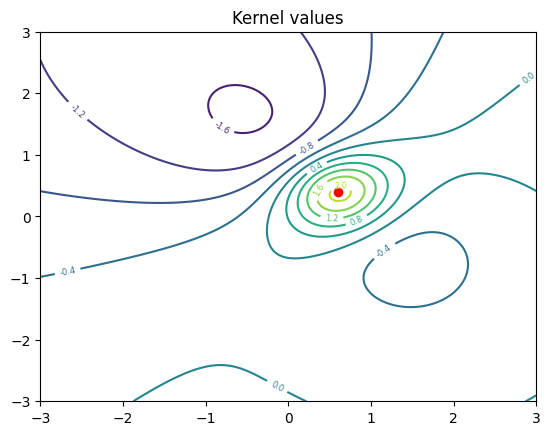

In [28]:
fig, ax = plt.subplots();
show_contour(ax, kernel, 'Kernel values')

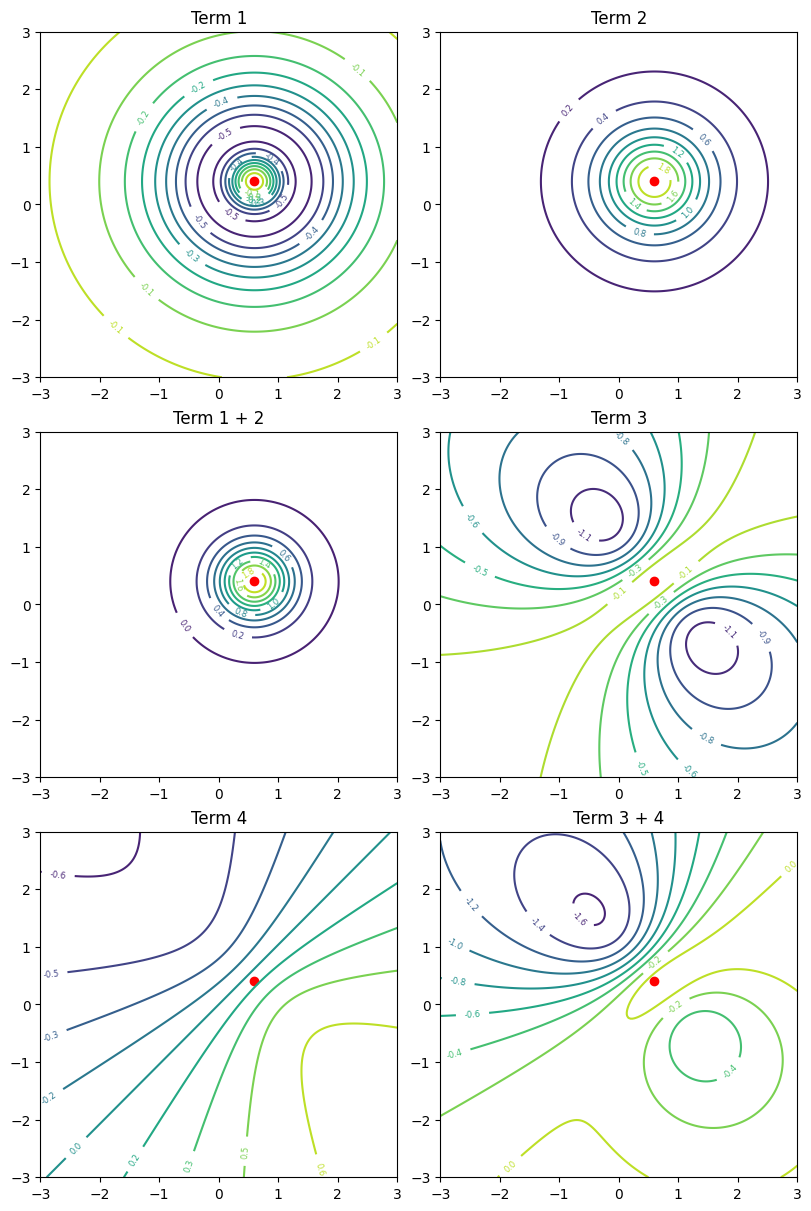

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12), constrained_layout=True);
show_contour(axs[0][0], t1, 'Term 1')
show_contour(axs[0][1], t2, 'Term 2')
show_contour(axs[1][0], t1 + t2, 'Term 1 + 2')
show_contour(axs[1][1], t3, 'Term 3')
show_contour(axs[2][0], t4, 'Term 4')
show_contour(axs[2][1], t3 + t4, 'Term 3 + 4')